<a href="https://colab.research.google.com/github/HubertasVin/deep-learning-practice/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importuojamos reikalingos bibliotekos

In [14]:
!pip install pyngrok

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from google.colab import drive
from flask import Flask, request, jsonify
from IPython import get_ipython
from pyngrok import ngrok

from google.colab import drive
drive.mount('/content/drive')

# Authtoken'a galima rasti cia: https://dashboard.ngrok.com/get-started/your-authtoken
ngrok.set_auth_token("2v8l4mW8zOFneFzX7p47qORuEwS_4EcRU64N6iq1mUNEpXN3G")

public_url = ngrok.connect(5000)
print("Public URL:", public_url)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

DATA_DIR = '/content/drive/MyDrive/colab_content/OpenImages'
TRAIN_MODE = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Public URL: NgrokTunnel: "https://5ee7-34-16-170-133.ngrok-free.app" -> "http://localhost:5000"
Using device: cuda:0


Duomenų įkėlimas ir paruošimas

In [27]:
# Naudojame image_dataset_from_directory funkciją, kuri automatiškai padalina duomenis
# į mokymo (training) ir validacijos (validation) aibes pagal nurodytą validacijos split
transforms_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

transforms_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Only consider directories within root_dir
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        print("Found classes:", self.classes)

        self.image_paths = []
        self.labels = []

        # Loop through each class folder and look for an 'images' subdirectory
        for cls in self.classes:
            cls_images_dir = os.path.join(root_dir, cls, "images")
            if os.path.isdir(cls_images_dir):
                files = os.listdir(cls_images_dir)
                print(f"Found {len(files)} files in {cls_images_dir}")
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        full_path = os.path.join(cls_images_dir, file)
                        self.image_paths.append(full_path)
                        self.labels.append(self.class_to_idx[cls])
            else:
                print(f"Warning: Expected directory '{cls_images_dir}' not found.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

dataset = CustomDataset(DATA_DIR, transform=transforms_train)
print("Total image count:", len(dataset))

# Padaliname duomenų rinkinį į mokymo (80%) ir testavimo (20%) aibes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
dataset_train, dataset_test = random_split(dataset, [train_size, test_size])
print("Train size: ", train_size);
print("Test size: ", test_size);

# Ta testavimo aibė naudosime kitą transformaciją (be duomenų augmentacijos)
dataset_test.dataset.transform = transforms_test

# Sukuriame DataLoader'us
batch_size = 16
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=2)

Found classes: ['sandal', 'strawberry', 'traffic light']
Found 301 files in /content/drive/MyDrive/colab_content/OpenImages/sandal/images
Found 380 files in /content/drive/MyDrive/colab_content/OpenImages/strawberry/images
Found 380 files in /content/drive/MyDrive/colab_content/OpenImages/traffic light/images
Total image count: 1061
Train size:  848
Test size:  213


Modelio sukūrimas

In [28]:
class CustomModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CustomModel, self).__init__()
        # Pirmasis blokas
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Antrasis blokas
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pilnai sujungti sluoksniai
        # Skaičiuojame flatten dydį: pradinė nuotraukos dydis 128x128, po dviejų 2x2 pool sluoksnių -> 32x32
        self.fc1 = nn.Linear(128 * 32 * 32, 516)
        self.fc2 = nn.Linear(516, 224)
        self.fc3 = nn.Linear(224, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.relu(self.conv3(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

num_classes = len(dataset.classes)
model = CustomModel(in_channels=3, num_classes=num_classes).to(device)
print("Parameter count:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Parameter count: 67862727


Treniravimo ciklas

In [29]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

def train_model(num_epochs=10, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    for epoch in range(num_epochs):
        loss = train_one_epoch(model, loader_train, criterion, optimizer)
        train_losses.append(loss)
        preds, labels = evaluate(model, loader_test)
        acc = accuracy_score(labels, preds)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss:.4f} - Test Accuracy: {acc:.4f}")
    # Save the model after training
    torch.save(model.state_dict(), "custom_model.pth")
    return train_losses

Įjungti / išjungti treniravimo režimą

Training new model...
Epoch 1/10 - Loss: 0.0805 - Test Accuracy: 0.7371
Epoch 2/10 - Loss: 0.0611 - Test Accuracy: 0.7371
Epoch 3/10 - Loss: 0.0520 - Test Accuracy: 0.7324
Epoch 4/10 - Loss: 0.0457 - Test Accuracy: 0.7371
Epoch 5/10 - Loss: 0.0407 - Test Accuracy: 0.7371
Epoch 6/10 - Loss: 0.0369 - Test Accuracy: 0.7371
Epoch 7/10 - Loss: 0.0334 - Test Accuracy: 0.7277
Epoch 8/10 - Loss: 0.0306 - Test Accuracy: 0.7277
Epoch 9/10 - Loss: 0.0279 - Test Accuracy: 0.7277
Epoch 10/10 - Loss: 0.0254 - Test Accuracy: 0.7277


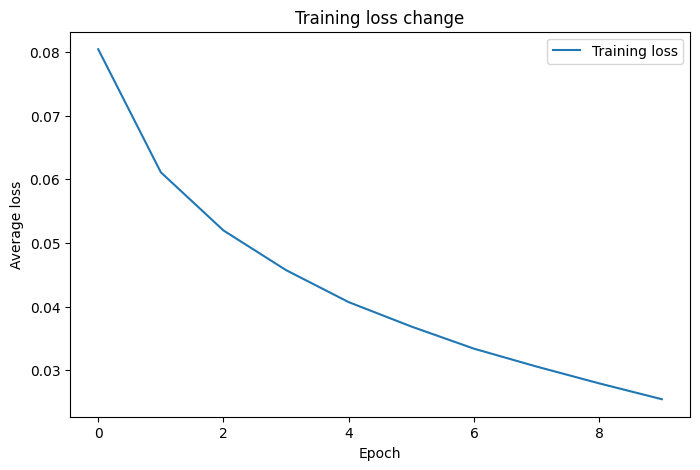

In [31]:
if TRAIN_MODE:
    print("Training new model...")
    train_losses = train_model(num_epochs=10, lr=1e-5)
    # Plot training loss history
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average loss')
    plt.title('Training loss change')
    plt.legend()
    plt.show()
else:
    print("Loading existing model...")
    model.load_state_dict(torch.load("custom_model.pth", map_location=device))
    model.eval()

Install ngrok and check the ip

In [32]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip -o ngrok-stable-linux-amd64.zip

# get_ipython().system_raw('python app.py &')
# get_ipython().system_raw('./ngrok http 5000 &')

# !curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

API skirtas įvesti nuotraukas rankiniu būdu

In [ ]:
app = Flask(__name__)

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# Helper function to predict a single image
def predict_image(image_input):
    # image_input can be a PIL.Image; apply test transforms
    image = transforms_test(image_input)
    image = image.unsqueeze(0).to(device)
    outputs = model(image)
    pred = torch.argmax(outputs, dim=1).item()
    # Reverse mapping from index to class name
    idx_to_class = {idx: cls for cls, idx in dataset.class_to_idx.items()}
    return idx_to_class.get(pred, "Unknown")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    if "url" in data:
        # Load image from URL
        import requests
        from io import BytesIO
        response = requests.get(data["url"])
        image = Image.open(BytesIO(response.content))
    elif "file_path" in data:
        # Load image from local file path
        image = Image.open(data["file_path"])
    else:
        return jsonify({"error": "Please provide 'url' or 'file_path' parameter."}), 400

    # Get prediction
    prediction = predict_image(image)
    return jsonify({"prediction": prediction})

# @app.route('/', methods=['GET'])
# def home():
#     return jsonify({"Test": "test"})

# To run the API, use: python main.py api
if __name__ == '__main__':
    import sys
    # if len(sys.argv) > 1 and sys.argv[1] == 'api':
    #     # Run the Flask API
    print("Starting API...")
    app.run(host='0.0.0.0', port=5000)
    # else:
    #     print("Model training/evaluation complete. To run the API, use: python main.py api")

Modelio vertinimas ir metrikų skaičiavimas

In [34]:
preds, labels = evaluate(model, loader_test)
cm = confusion_matrix(labels, preds)
acc = accuracy_score(labels, preds)
prec = precision_score(labels, preds, average='weighted', zero_division=0)
rec = recall_score(labels, preds, average='weighted', zero_division=0)
f1 = f1_score(labels, preds, average='weighted', zero_division=0)

print("\nKlasifikacijos matrica:")
print(cm)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)


Klasifikacijos matrica:
[[41 11 10]
 [14 59  5]
 [12  6 55]]
Accuracy: 0.7276995305164319
Precision: 0.7316904833030653
Recall: 0.7276995305164319
F1: 0.7292532048509776


Treniruotės istorijos vizualizacija

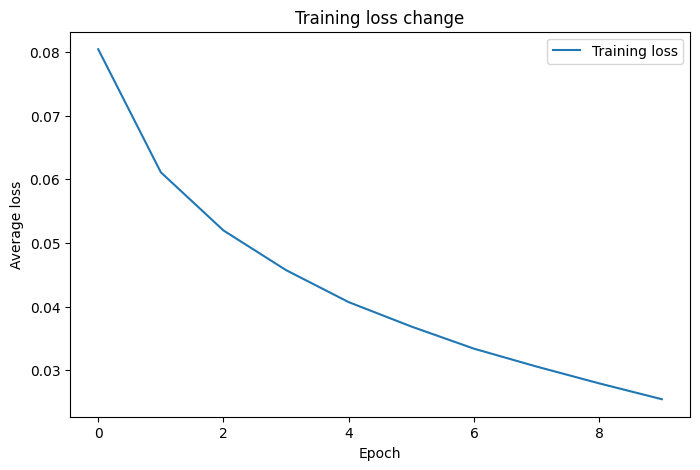

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.title('Training loss change')
plt.legend()
plt.show()